<img style="float: left;" src="figures/Model2.png" width="20%">

# <font color='Red'>  Typical gas field model</font>

## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 2D gas reservoir.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [CompositionalPhysics](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/physics.py) for compositional physics
 * Class [PropertyContainer](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/property_container.py) for allocating property evaluators needed in simulation
 * Class [CompositionalOperators](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/operator_evaluator.py) for defining OBL operators in simulation
 
 
2. Change simulation between methane production and CO$_2$ injection
3. Check well performance

## <font color='blue'>Let's start !</font>
### Step 1. We need to import <font color='red'>engines</font> and nessesary physical properties into the workspace, just like the import of commonly-used modules such as numpy etc.

In [1]:
'''Import all important packages from DARTS installation'''
import numpy as np
import pandas as pd
import sys
from darts.engines import value_vector, redirect_darts_output, sim_params
import matplotlib.pyplot as plt

from darts.reservoirs.struct_reservoir import StructReservoir
from darts.models.darts_model import DartsModel

from darts.physics.super.physics import Compositional
from darts.physics.super.property_container import PropertyContainer
from darts.physics.super.operator_evaluator import PropertyOperators

from darts.physics.properties.flash import ConstantK
from darts.physics.properties.basic import ConstFunc, PhaseRelPerm
from darts.physics.properties.density import DensityBasic

In [2]:
dir(darts)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

## <font color='Blue'>Brief Introduction of model inheritance:</font>

* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [2]:
class Model(DartsModel):
    def __init__(self):
        # Call base class constructor
        super().__init__()

        # Measure time spend on reading/initialization
        self.timer.node["initialization"].start()

    def set_reservoir(self):
        nx = 200
        ny = 1
        nz = 100
        nb = nx * ny * nz
        self.dx = 2
        self.dz = 2
        depth = np.zeros(nb)
        n_layer = nx*ny
        for k in range(nz):
            depth[k*n_layer:(k+1)*n_layer] = 2000 + k * self.dz

        # activate only a part of domain to mimic gas reservoir
        self.actnum = np.zeros(nb)
        for i in range(nz):
            self.actnum[i*nx+nz-i:i*nx+nx-i] = 1

        reservoir = StructReservoir(self.timer, nx, ny, nz, dx=self.dx, dy=20, dz=self.dz, actnum=self.actnum,
                                    permx=100, permy=100, permz=10, hcap=2200, rcond=100, poro=0.2, depth=depth)

        res = super().set_reservoir(reservoir)
        
        volume = np.array(reservoir.mesh.volume, copy=False)
        poro = np.array(reservoir.mesh.poro, copy=False)
        print("Pore volume = " + str(sum(volume * poro)))

        # add large volume to teh last layer to mimic a large auifer
        volume[-nz:] = 1e8

        return res

    def set_wells(self, name='I'):
        nx = self.reservoir.nx
        nz = self.reservoir.nz

        self.reservoir.add_well(name)
        # add well to teh middle of active zone
        self.reservoir.add_perforation(name, cell_index=(int((nx+nz)/2), 1, 1), well_radius=0.1, well_indexD=0)

        return super().set_wells()

    def set_initial_conditions(self, initial_values: dict = None, gradient: dict = None):
        super().set_initial_conditions()
        depth = np.array(self.reservoir.mesh.depth, copy=False)
        values = np.array(self.reservoir.mesh.composition, copy=False)

        # introduce gas-water contact
        depth_gwc = 2100

        zCO2 = values[0::(self.physics.nc - 1)]
        zCO2[depth > depth_gwc] = self.zero

        zC1 = values[1::(self.physics.nc - 1)]
        zC1[depth > depth_gwc] = self.zero

    def set_physics(self):
        """Physical properties"""
        self.zero = 1e-12
        # Create property containers:
        components = ['CO2', 'C1', 'H2O']
        phases = ['gas', 'wat']
        thermal = 0
        Mw = [44.01, 16.04, 18.015]

        property_container = PropertyContainer(phases_name=phases, components_name=components,
                                               Mw=Mw, min_z=self.zero / 10, temperature=1.)

        """ properties correlations """
        property_container.flash_ev = ConstantK(len(components), [80, 20, 1e-2], self.zero)
        property_container.density_ev = dict([('gas', DensityBasic(compr=1e-3, dens0=200)),
                                              ('wat', DensityBasic(compr=1e-5, dens0=900))])
        property_container.viscosity_ev = dict([('gas', ConstFunc(0.05)),
                                                ('wat', ConstFunc(0.5))])
        property_container.rel_perm_ev = dict([('gas', PhaseRelPerm("gas", sgr=0.1)),
                                               ('wat', PhaseRelPerm("oil", swc=0.25))])

        """ Activate physics """
        physics = Compositional(components, phases, self.timer,
                                n_points=200, min_p=1, max_p=300, min_z=self.zero/10, max_z=1-self.zero/10)
        physics.add_property_region(property_container)
        
        # additional properties to report
        props = [('Brine saturation', 'sat', 1), ('Gas saturation', 'sat', 0)]
        physics.add_property_operators(PropertyOperators(props, property_container))

        return super().set_physics(physics)

    def set_well_controls(self):
        # inejct pure CO2
        inj_stream = [1.0 - 2 * self.zero, self.zero]
        
        # two types of well control
        for i, w in enumerate(self.reservoir.wells):
            if 'I' in w.name:
                w.control = self.physics.new_rate_inj(1000, inj_stream, 0)
                w.constraint = self.physics.new_bhp_inj(230, inj_stream)
            else:
                w.control = self.physics.new_rate_prod(1000, 0)
                w.constraint = self.physics.new_bhp_prod(30)


In [3]:
def plot2D(m):    
    nx = m.reservoir.nx
    nz = m.reservoir.nz

    x = np.linspace(nx * m.dx, 0, nx)
    y = np.linspace(nz * m.dz, 0, nz)
    
    properties = m.physics.vars + m.physics.property_operators.props_name
    output = m.output_properties()        

    act = m.actnum
    arr = np.ones(nx * nz) * np.nan
    plt.rcParams['pcolor.shading'] ='nearest'
    print_props = [0, 2, 3]
    
    fig, axs = plt.subplots(len(print_props), 1, figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')
    for i, ith_prop in enumerate(print_props):
        # plot array defined in active cells only
        arr[act > 0] = output[ith_prop, :]
        prop = axs[i].pcolor(x, y, arr.reshape(nz, nx))
        plt.colorbar(prop, ax=axs[i]) 
        axs[i].set_title(properties[ith_prop])
        axs[i].axis('off')        
    
    plt.tight_layout()

In [ ]:
m = Model()
m.set_reservoir()
well_name = "I"
m.set_wells(well_name)
m.set_physics()
m.set_sim_params(first_ts=0.001, mult_ts=2, max_ts=5, runtime=1000, tol_newton=1e-2, tol_linear=1e-3,
                 it_newton=10, it_linear=50, newton_type=sim_params.newton_local_chop)

# find CH4 composition corresponding with particular gas saturation 
z_range = np.linspace(m.zero, 1 - m.zero, 200)
for z in z_range:
    # state is pressure and 2 molar fractions out of 3
    state = [30, m.zero, z]
    sat = m.physics.property_operators.property_container.compute_saturation_full(state)
    if sat > 0.8:
        break

m.initial_values = {m.physics.vars[0]: state[0],
                    m.physics.vars[1]: state[1],
                    m.physics.vars[2]: state[2]}

m.init()

plot2D(m)
plt.show()

# run simulation for a year
m.run_python(365)

# print statistics and timers
m.print_timers()
m.print_stat()

C:\Users\924878\AppData\Local\Temp\ipykernel_12752\1102453923.py:21: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(prop, ax=axs[i])


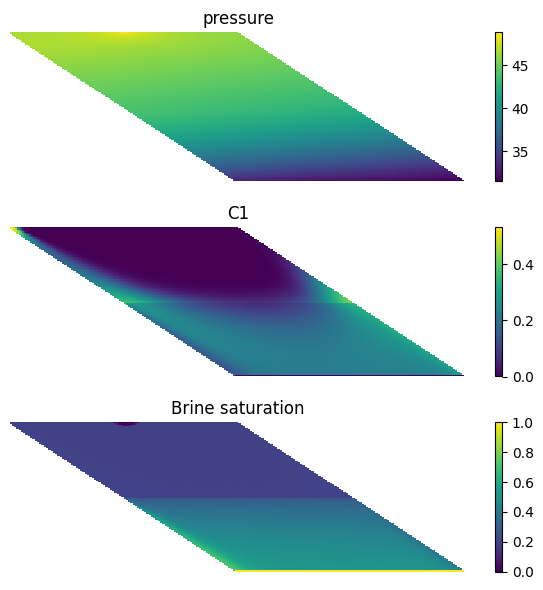

In [5]:
plot2D(m)
plt.show()

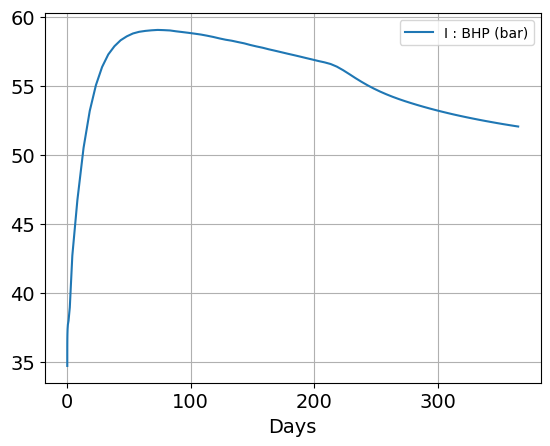

In [8]:
### plot production information
td = pd.DataFrame.from_dict(m.engine.time_data)
string = well_name + ' : BHP'
ax1 = td.plot(x='time', y=[col for col in td.columns if string in col])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Days', fontsize=14)
plt.grid()
plt.show()

## <font color='Blue'>Tasks in this workshop (check and explain why solution behave this way):</font>

1. Remove large aquifer and check production.
2. Switch from production to injection, reduce initial pressure to 30 bars.
3. Add large aquifer again and compare the production.

## Original production
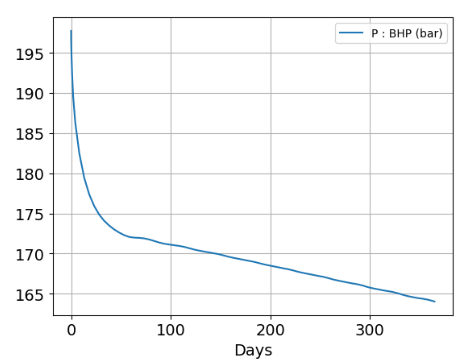

## Romove large aquifer and check production
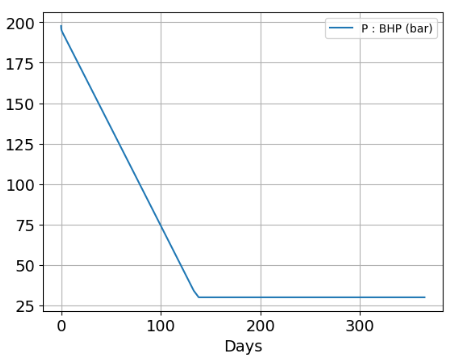

## Switch from production to injection, reduce intitial pressure to 30 bars
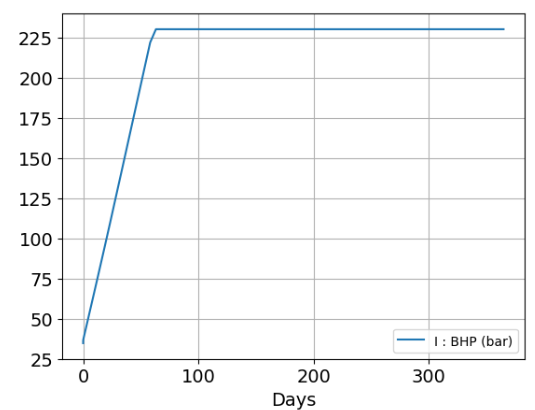

## Add large aquifer again and compare the production
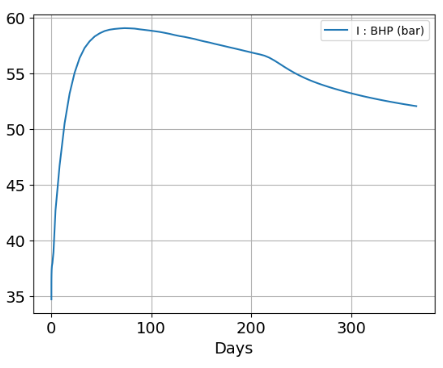